In [1]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline

import pandas


def simTransform(pref, pcmp, showerror = False):
    err_before = np.mean(np.sum(np.square(pref - pcmp), axis=1))
    ref_mean = np.mean(pref, axis=0)
    prefcentered = np.asmatrix(pref) - np.asmatrix(ref_mean)
    
    cmp_mean = np.mean(pcmp, axis=0)
    pcmpcentered = np.asmatrix(pcmp) - np.asmatrix(cmp_mean)   
    
    Sxx = np.sum(np.square(pcmpcentered[:,0]))
    Syy = np.sum(np.square(pcmpcentered[:,1]))
    Sxxr = prefcentered[:,0].T * pcmpcentered[:,0] #(ref_x, x)
    Syyr = prefcentered[:,1].T * pcmpcentered[:,1] #(ref_y, y)
    Sxyr = prefcentered[:,1].T * pcmpcentered[:,0] #(ref_y, x)
    Syxr = prefcentered[:,0].T * pcmpcentered[:,1] #(ref_x, y)
    a = (Sxxr + Syyr)/(Sxx + Syy) #(Sxxr + Syyr) / (Sxx + Syy)
    b = (Sxyr - Syxr) / (Sxx + Syy)
    a = np.asscalar(a)
    b = np.asscalar(b)
    Rot = np.matrix([[a, -b],[b, a]])
    translation = -Rot * np.asmatrix(cmp_mean).T + np.asmatrix(ref_mean).T
    outx, outy = [], []
    res = Rot * np.asmatrix(pcmp).T + translation
    
    if showerror:
        err_after = np.mean(np.sum(np.square(pref - res.T), axis=1))
        print("Error before: %.4f    after: %.4f\n"%(err_before, err_after))
    return np.asarray(res.T)
    

def draw_shape(img, points, color, closed=False):
    #print(points)
    imgout = img.copy()
    prev_point = points[0,:]
    for p in points[1:,:]:
        cv2.line(imgout, tuple(prev_point), tuple(p), 
                 color=color, thickness=2)
        prev_point = p
    if closed:
        cv2.line(imgout, tuple(prev_point), tuple(points[0,:]), 
                 color=color, thickness=2)
        
    return imgout

def genMask(src, tri):
    mask = np.zeros(src.shape, dtype = src.dtype)
    cv2.fillConvexPoly(mask, np.int32(tri), (1.0, 1.0, 1.0), 16, 0);
    return mask

################################
# Apply affine transform calculated using srcTri and dstTri to src and
# output an image of size.
def applyAffineTransform(src, srcTri, dstTri, size) :
    
    # Given a pair of triangles, find the affine transform.
    warpMat = cv2.getAffineTransform( np.float32(srcTri), np.float32(dstTri) )
    
    #rbound = cv2.boundingRect(np.float32([dstTri]))
    #print(rbound)
    #size = (rbound[2], rbound[3])
    # Apply the Affine Transform just found to the src image
    dst = cv2.warpAffine( src, warpMat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 )

    return dst

def warpTriangle(img1, img2, t1, t2):
    """ Warping triangular patch from image 1 onto image 2
    """
    
    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))
    
    t1_local, t2_local = [], []
    for i in range(3):
        t1_local.append(((t1[i][0] - r1[0]), t1[i][1] - r1[1]))
        t2_local.append(((t2[i][0] - r2[0]), t2[i][1] - r2[1]))
        
    #mask1 = np.zeros((r1[3], r1[2], 3), dtype = np.float32)
    mask_t2 = np.zeros((r2[3], r2[2], 3), dtype = np.float32)
    #cv2.fillConvexPoly(mask1, np.int32(t1_local), (1.0, 1.0, 1.0), 16, 0)
    cv2.fillConvexPoly(mask_t2, np.int32(t2_local), (1.0, 1.0, 1.0), 16, 0)
    
    x1left, x1right, y1left, y1right = r1[1], r1[1]+r1[3], r1[0], r1[0]+r1[2]
    x2left, x2right, y2left, y2right = r2[1], r2[1]+r2[3], r2[0], r2[0]+r2[2]
    
    img1_patch = img1[x1left:x1right, y1left:y1right]
    img2_patch = img2[x2left:x2right, y2left:y2right]
    
    img1_patch_warped = applyAffineTransform(img1_patch, t1_local, t2_local, (r2[2], r2[3]))
    #img2_patch_warped = applyAffineTransform(img2_patch, t2_local, t1_local, (r1[2], r1[3]))
    #print(mask2.shape, img1_patch.shape, img1_patch_warped.shape)
    img1_patch_warped = img1_patch_warped * mask_t2
    #img2_patch_warped = img2_patch_warped * mask1
    
    #out1[x1left:x1right, y1left:y1right] = img1_patch * ( (1.0, 1.0, 1.0) - mask1)
    img2[x2left:x2right, y2left:y2right] = img2_patch * ( (1.0, 1.0, 1.0) - mask_t2)
    
    #out1[x1left:x1right, y1left:y1right] = img1_patch + img2_patch_warped
    img2[x2left:x2right, y2left:y2right] = img2_patch + img1_patch_warped



################################
# Check if a point is inside a rectangle
def rectContains(rect, point) :
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[0] + rect[2] :
        return False
    elif point[1] > rect[1] + rect[3] :
        return False
    return True


#calculate delanauy triangle
def calculateDelaunayTriangles(rect, points):
    #create subdiv
    subdiv = cv2.Subdiv2D(rect);
    
    # Insert points into subdiv
    for p in points:
        subdiv.insert(p) 
    
    triangleList = subdiv.getTriangleList();
    
    delaunayTri = []
    
    pt = []    
    
    count= 0    
    
    for t in triangleList:        
        pt.append((t[0], t[1]))
        pt.append((t[2], t[3]))
        pt.append((t[4], t[5]))
        
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])        
        
        if rectContains(rect, pt1) and rectContains(rect, pt2) and rectContains(rect, pt3):
            count = count + 1 
            ind = []
            for j in range(0, 3):
                for k in range(0, len(points)):                    
                    if(abs(pt[j][0] - points[k][0]) < 1.0 and abs(pt[j][1] - points[k][1]) < 1.0):
                        ind.append(k)                            
            if len(ind) == 3:                                                
                delaunayTri.append((ind[0], ind[1], ind[2]))
        
        pt = []        
            
    
    return delaunayTri

def CloneSeamless(obj, srcimg, hullpoints):
    mask = np.zeros(obj.shape, dtype = obj.dtype) 
    
    hull = tuple(map(tuple, hullpoints))
    cv2.fillConvexPoly(mask, np.int32(hull), (255, 255, 255))
    print(hull)
    r = cv2.boundingRect(np.float32([hullpoints]))    
    
    center = ((r[0]+int(r[2]/2), r[1]+int(r[3]/2)))
    output = cv2.seamlessClone(np.uint8(obj), srcimg, mask, center, cv2.NORMAL_CLONE)
    
    return output

In [2]:
df = pandas.read_csv('muct76-opencv.csv', header=0, usecols=np.arange(2,154), dtype=float)

df.head()

,x00,y00,x01,y01,x02,y02,x03,y03,x04,y04,...,x71,y71,x72,y72,x73,y73,x74,y74,x75,y75
0,201.0,348.0,201.0,381.0,202.0,408.0,209.0,435.0,224.0,461.0,...,235.5,348.5,338.0,333.5,324.0,335.5,326.0,342.5,340.0,340.5
1,162.0,357.0,157.0,387.0,160.0,418.0,167.0,446.0,182.0,477.0,...,202.5,359.0,305.5,346.0,291.5,348.0,292.0,354.5,306.0,352.5
2,212.0,352.0,203.0,380.0,200.0,407.0,211.0,439.0,224.0,479.0,...,257.5,355.0,344.5,343.5,334.0,345.0,335.0,351.0,345.5,349.5
3,157.0,316.0,155.0,348.0,154.0,373.0,159.0,407.0,172.0,435.0,...,192.0,319.0,295.5,311.5,280.0,313.0,282.0,320.0,297.5,318.5
4,201.0,373.0,200.0,408.0,203.0,433.0,213.0,463.0,226.0,481.0,...,237.0,377.5,335.5,366.5,322.0,369.0,324.5,375.0,338.0,372.5


In [3]:
X = df.iloc[:, ::2].values
Y = df.iloc[:, 1::2].values

print(X.shape, Y.shape)
d = np.hstack((X,Y))
print(d.shape)

(7510, 76) (7510, 76)
(7510, 152)


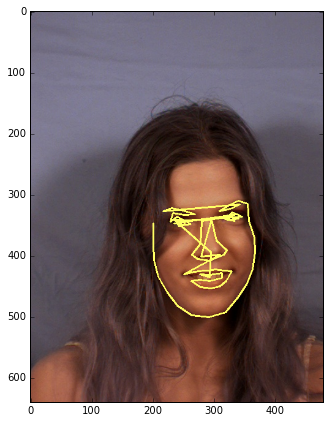

In [4]:

img1 = cv2.imread('figs/front-image.jpg')


points1 = np.vstack ((X[0,:], Y[0,:])).T    # i000qa-fn

points1 = points1.astype(int)

### Plot
plt.figure(figsize=(7,7))
img1shape = draw_shape(img1, points1[:,:], color=(100,255,255))
plt.imshow(cv2.cvtColor(img1shape, cv2.COLOR_BGR2RGB))
plt.show()

In [5]:
x0 = 5
x1 = img1.shape[1]/3-5
x2 = img1.shape[1]*2/3-5
x3 = img1.shape[1]-5
y0 = 5
y1 = img1.shape[0]/4-5
y2 = img1.shape[0]/2-5
y3 = img1.shape[0]*3/4-5
y4 = img1.shape[0]-5

imgborders = np.array([(x0,y0), (x0,y1), (x0,y2), (x0,y3), (x0,y4),
                       (x3,y0), (x3,y1), (x3,y2), (x3,y3), (x3,y4),
                       (x1,y0), (x2,y0),  (x1,y4), (x2,y4)])
imgborders = imgborders.astype(int)
print(imgborders.shape)
allpoints = np.vstack((points1, imgborders))
print(allpoints.shape)


(14, 2)
(90, 2)


In [7]:
meanface = np.load('models/meanshape-ocvfmt.pkl')

meanface_transformed = simTransform(points1, meanface).astype(int)
print(meanface_transformed.shape)

allpoints_mean = np.vstack((meanface_transformed, imgborders)).astype(int)
allpoints_mean = np.asarray(allpoints_mean)
print(allpoints_mean.shape)

(76, 2)
(90, 2)


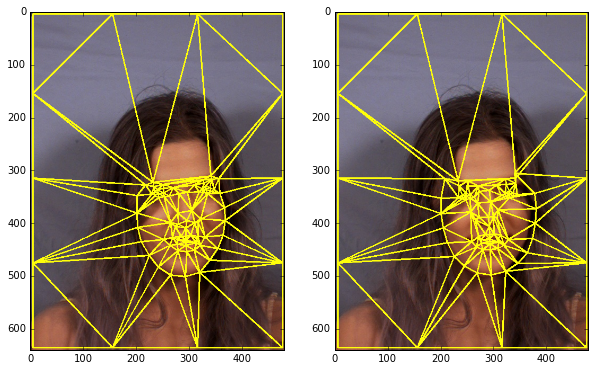

In [8]:
sizeImg1 = img1.shape    
rect = (0, 0, sizeImg1[1], sizeImg1[0])

trilist = calculateDelaunayTriangles(rect, tuple(map(tuple, allpoints)))

tmp1 = img1.copy()
tmp2 = img1.copy()


for tri in trilist:
    tp1 = allpoints[tri, :]
    tp2 = allpoints_mean[tri, :]
    tmp1 = draw_shape(tmp1, tp1, (10,255,255), True)
    tmp2 = draw_shape(tmp2, tp2, (10,255,255), True)
    
plt.figure(figsize=(10,16))
plt.subplot(1,2, 1)
plt.imshow(cv2.cvtColor(tmp1, cv2.COLOR_BGR2RGB))
plt.subplot(1,2, 2)
plt.imshow(cv2.cvtColor(tmp2, cv2.COLOR_BGR2RGB))
plt.show()

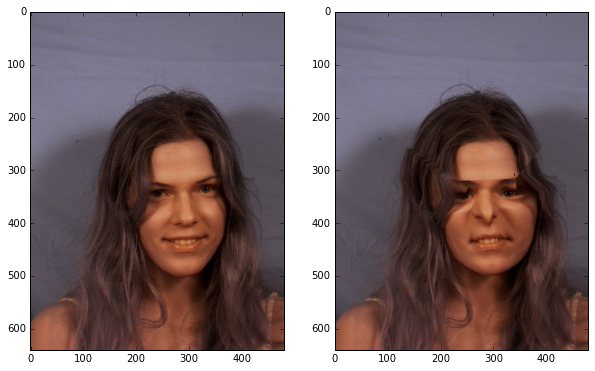

In [9]:
res = img1.copy()
for tri in trilist:
    tp1 = allpoints[np.array(tri),:]
    tp2 = allpoints_mean[np.array(tri),:]
    warpTriangle(img1, res, tp1, tp2)

    
plt.figure(figsize=(10,12))
plt.subplot(1,2, 1)
plt.imshow(cv2.cvtColor(img1 , cv2.COLOR_BGR2RGB))
plt.subplot(1,2, 2)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
plt.show()

((366, 371), (367, 395), (363, 423), (353, 448), (338, 470), (319, 493), (292, 501), (264, 498), (241, 483), (224, 461), (209, 435), (202, 408), (201, 381), (201, 348), (217, 328), (355, 316), (357, 344))


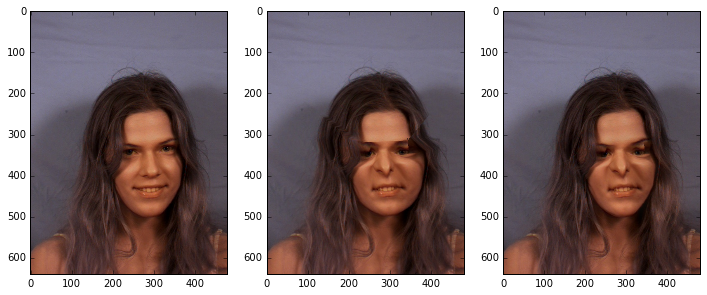

In [10]:
hull = []

hullIndex = cv2.convexHull(meanface_transformed, returnPoints = False)

for i in range(0, len(hullIndex)):
    hull.append(tuple(points1[hullIndex.flatten()[i]]))


out = CloneSeamless(res, img1, hull)

plt.figure(figsize=(12,10))
plt.subplot(1,3, 1)
plt.imshow(cv2.cvtColor(img1 , cv2.COLOR_BGR2RGB))
plt.subplot(1,3, 2)
plt.imshow(cv2.cvtColor(res , cv2.COLOR_BGR2RGB))
plt.subplot(1,3, 3)
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
plt.show()

### Eigen vectors

In [15]:
Phi_matrix = np.matrix(np.load('models/phimatrix.pkl'))
meanvector = np.matrix(np.load('models/meanvector.pkl'))
alignedfaces = np.matrix(np.load('models/alignedfaces.pkl'))
bvector = np.matrix(np.load('models/bvector.pkl'))

print("Phi: ", Phi_matrix.shape)
print("mean: ", meanvector.shape)
print("alignedfaces: ", alignedfaces.shape)
print("b: ", bvector.shape)

Phi:  (152, 8)
mean:  (152, 1)
alignedfaces:  (7510, 152)
b:  (7510, 8)


In [13]:
bvector[0,:]

matrix([[-0.05254929, -0.05384175,  0.01253576, -0.001874  , -0.00039057,
          0.00113446, -0.00701092, -0.00217791]])

In [20]:
new_shape = meanvector + Phi_matrix * bvector[0,:].T

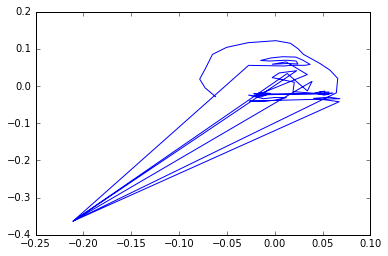

In [55]:
plt.figure()
plt.plot(np.array(alignedfaces[2,:76])[0], np.array(alignedfaces[2,76:])[0])
plt.show()

In [42]:
np.array(alignedfaces[0,:76])[0]

array([-0.14950533, -0.14950533, -0.14781425, -0.13597665, -0.11061036,
       -0.0818619 , -0.04296693,  0.00438347,  0.05004279,  0.08217342,
        0.1075397 ,  0.12445056,  0.1312149 ,  0.12952382,  0.11430405,
        0.11092188,  0.08555559,  0.0601893 ,  0.03313193,  0.06357147,
        0.08893776, -0.12244796, -0.09877276, -0.06664213, -0.0345115 ,
       -0.06495104, -0.09539059, -0.10215493, -0.08355299, -0.0463491 ,
       -0.08017082, -0.0818619 ,  0.0957021 ,  0.06864473,  0.0483517 ,
        0.07540907,  0.06864473, -0.01590956, -0.01929173, -0.04296693,
       -0.02774716,  0.00607456,  0.04496953,  0.05342496,  0.0246765 ,
        0.01114782, -0.01760064,  0.03482302, -0.06495104, -0.03620259,
       -0.00914521,  0.00607456,  0.02129433,  0.04496953,  0.06695365,
        0.05173387,  0.03313193,  0.00945673, -0.01929173, -0.04465801,
       -0.02098281,  0.00607456,  0.03989627,  0.03989627,  0.00607456,
       -0.02098281,  0.00607456,  0.00945673, -0.09285396, -0.06